<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Lab 3.02: Statistical Modeling and Model Validation

> Authors: Tim Book, Matt Brems

---

## Objective
The goal of this lab is to guide you through the modeling workflow to produce the best model you can. In this lesson, you will follow all best practices when slicing your data and validating your model. 

## Imports

In [72]:
# Import everything you need here.
# You may want to return to this cell to import more things later in the lab.
# DO NOT COPY AND PASTE FROM OUR CLASS SLIDES!
# Muscle memory is important!

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score,  GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
%matplotlib inline


## Read Data
The `citibike` dataset consists of Citi Bike ridership data for over 224,000 rides in February 2014.

In [73]:
# Read in the citibike data in the data folder in this repository.
citibike = pd.read_csv('./data/citibike_feb2014.csv')

## Explore the data
Use this space to familiarize yourself with the data.

Convince yourself there are no issues with the data. If you find any issues, clean them here.

In [74]:
citibike.shape

(224736, 15)

In [75]:
citibike.isnull().sum().sum()

0

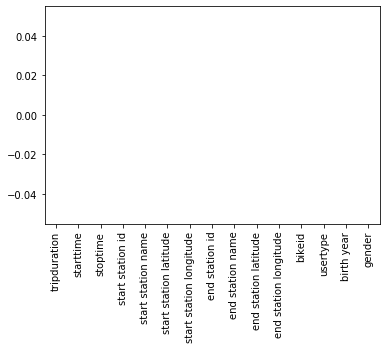

In [76]:
citibike.isnull().sum().plot(kind='bar');

In [77]:
citibike.head(2)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,382,2014-02-01 00:00:00,2014-02-01 00:06:22,294,Washington Square E,40.730494,-73.995721,265,Stanton St & Chrystie St,40.722293,-73.991475,21101,Subscriber,1991,1
1,372,2014-02-01 00:00:03,2014-02-01 00:06:15,285,Broadway & E 14 St,40.734546,-73.990741,439,E 4 St & 2 Ave,40.726281,-73.989780,15456,Subscriber,1979,2


In [78]:
citibike.dtypes

tripduration                 int64
starttime                   object
stoptime                    object
start station id             int64
start station name          object
start station latitude     float64
start station longitude    float64
end station id               int64
end station name            object
end station latitude       float64
end station longitude      float64
bikeid                       int64
usertype                    object
birth year                  object
gender                       int64
dtype: object

In [79]:
citibike.describe().T

,count,mean,std,min,25%,50%,75%,max
tripduration,224736.0,874.519810,5486.092219,60.000000,360.000000,544.000000,845.000000,766108.000000
start station id,224736.0,439.203479,335.723861,72.000000,305.000000,403.000000,490.000000,3002.000000
start station latitude,224736.0,40.734366,0.019031,40.680342,40.721854,40.736197,40.749156,40.770513
start station longitude,224736.0,-73.990386,0.011853,-74.017134,-73.998522,-73.990617,-73.981918,-73.950048
end station id,224736.0,440.741995,341.497433,72.000000,305.000000,403.000000,488.000000,3002.000000
end station latitude,224736.0,40.734221,0.019048,40.680342,40.721816,40.735877,40.749013,40.770513
end station longitude,224736.0,-73.990521,0.011920,-74.017134,-73.999061,-73.990741,-73.981948,-73.950048
bikeid,224736.0,18010.598222,1987.769335,14529.000000,16302.000000,17975.000000,19689.000000,21542.000000
gender,224736.0,1.154617,0.436592,0.000000,1.000000,1.000000,1.000000,2.000000


In [80]:
citibike.gender.unique()

array([1, 2, 0], dtype=int64)

Further investigation into birth year shows we have an invalid entry. We'll make this entry 0 in order to convert

In [81]:
citibike['birth year'].unique()

array(['1991', '1979', '1948', '1981', '1990', '1978', '1944', '1983',
       '1969', '1986', '1962', '1965', '1942', '1989', '1980', '1957',
       '1951', '1992', '1971', '1982', '1968', '1984', '\\N', '1956',
       '1987', '1985', '1996', '1975', '1988', '1974', '1972', '1959',
       '1973', '1977', '1976', '1953', '1993', '1970', '1963', '1967',
       '1966', '1960', '1961', '1994', '1958', '1955', '1946', '1964',
       '1900', '1995', '1954', '1952', '1949', '1947', '1941', '1938',
       '1950', '1945', '1997', '1934', '1940', '1939', '1936', '1943',
       '1935', '1937', '1922', '1932', '1907', '1926', '1899', '1901',
       '1917', '1910', '1933', '1921', '1927', '1913'], dtype=object)

We'll grab the mean of all the non-issue years..

In [82]:
age_mean =pd.DataFrame(citibike.loc[citibike['birth year'] != '\\N','birth year']).astype('int').mean()

And apply to the //N values

In [83]:
age_mean[0]

1975.4975070980051

In [84]:
citibike.loc[citibike['birth year'] == '\\N','birth year'] = 1975

In [85]:
citibike['birth year'].unique()

array(['1991', '1979', '1948', '1981', '1990', '1978', '1944', '1983',
       '1969', '1986', '1962', '1965', '1942', '1989', '1980', '1957',
       '1951', '1992', '1971', '1982', '1968', '1984', 1975, '1956',
       '1987', '1985', '1996', '1975', '1988', '1974', '1972', '1959',
       '1973', '1977', '1976', '1953', '1993', '1970', '1963', '1967',
       '1966', '1960', '1961', '1994', '1958', '1955', '1946', '1964',
       '1900', '1995', '1954', '1952', '1949', '1947', '1941', '1938',
       '1950', '1945', '1997', '1934', '1940', '1939', '1936', '1943',
       '1935', '1937', '1922', '1932', '1907', '1926', '1899', '1901',
       '1917', '1910', '1933', '1921', '1927', '1913'], dtype=object)

In [86]:
citibike['birth year'] = citibike['birth year'].astype('int')

## Is average trip duration different by gender?

Conduct a hypothesis test that checks whether or not the average trip duration is different for `gender=1` and `gender=2`. Be sure to specify your null and alternative hypotheses, and to state your conclusion carefully and correctly!

**Null Hypothesis:** There is no difference in average trip duration between gender 1 and gender 2.

**Alt Hypothesis:** There is a difference in average trip duration between gender 1 and gender 2.

In [87]:
citibike.groupby('gender')['tripduration'].mean()

gender
0    1740.830932
1     814.032409
2     991.361074
Name: tripduration, dtype: float64

In [88]:
gender1 = citibike.loc[citibike['gender'] == 1,'tripduration']
gender2 = citibike.loc[citibike['gender'] == 2,'tripduration']

In [89]:
gender1.mean(), gender2.mean()

(814.0324088236293, 991.3610742785506)

In [90]:
from scipy import stats
stats.ttest_ind(gender1, gender2, equal_var=False)
t_stat, p_value = stats.ttest_ind(gender1, gender2, equal_var=False)

In [91]:
t_stat, p_value

(-4.802922158264667, 1.5680482053980446e-06)

Our p-value here is 1.56e-6, which is smaller than our established threshold of .05. Based on this, we reject our null hypothesis and in turn accept our alternative hypothesis. We have enough evidence to suggest that mean trip duration differs between genders.

## What numeric columns shouldn't be treated as numeric?

In [92]:
citibike.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender'],
      dtype='object')

In [93]:
citibike.dtypes

tripduration                 int64
starttime                   object
stoptime                    object
start station id             int64
start station name          object
start station latitude     float64
start station longitude    float64
end station id               int64
end station name            object
end station latitude       float64
end station longitude      float64
bikeid                       int64
usertype                    object
birth year                   int32
gender                       int64
dtype: object

**Answer:** Birthyear is one column that should be treated numerically, but there were a number of string values that were preventing us from appropriately treating it as such. We took some steps above to clean this column. usertype can also be numerically encoded.

In [94]:
citibike.usertype.unique()

array(['Subscriber', 'Customer'], dtype=object)

In [95]:
citibike.usertype = citibike.usertype.map({'Subscriber':1, 'Customer':0})

## Dummify the `start station id` Variable

In [96]:
citi_dummies = pd.get_dummies(citibike['start station id'], drop_first=True)

In [97]:
citibike.shape

(224736, 15)

In [98]:
combined = pd.concat([citibike,citi_dummies],axis=1);

In [99]:
citibike.shape, citi_dummies.shape, combined.shape

((224736, 15), (224736, 328), (224736, 343))

## Engineer a feature called `age` that shares how old the person would have been in 2014 (at the time the data was collected).

- Note: you will need to clean the data a bit.

In [100]:
combined['age'] = 2014 - combined['birth year']

In [117]:
combined['age'].describe()

count    224736.000000
mean         38.517363
std          11.252286
min          17.000000
25%          30.000000
50%          37.000000
75%          46.000000
max         115.000000
Name: age, dtype: float64

## Split your data into train/test data

Look at the size of your data. What is a good proportion for your split? **Justify your answer.**

Use the `tripduration` column as your `y` variable.

For your `X` variables, use `age`, `usertype`, `gender`, and the dummy variables you created from `start station id`. (Hint: You may find the Pandas `.drop()` method helpful here.)

**NOTE:** When doing your train/test split, please use random seed 123.

We have a significant number of observations here for training, over 22k. For that reason..

In [101]:
lr_col_list = list(citi_dummies.columns)

In [102]:
lr_col_list.extend(['age','usertype','gender'])

In [103]:
citi_dummies.shape

(224736, 328)

In [104]:
len(lr_col_list)

331

In [105]:
X = combined[lr_col_list]

In [106]:
y= combined['tripduration']

In [107]:
X.shape, citibike.shape

((224736, 331), (224736, 15))

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=3)

In [113]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
79,157315.0,0.002930,0.054054,0.0,0.0,0.0,0.0,1.0
82,157315.0,0.001252,0.035365,0.0,0.0,0.0,0.0,1.0
83,157315.0,0.001322,0.036338,0.0,0.0,0.0,0.0,1.0
116,157315.0,0.006039,0.077475,0.0,0.0,0.0,0.0,1.0
119,157315.0,0.000222,0.014914,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
2023,157315.0,0.001443,0.037959,0.0,0.0,0.0,0.0,1.0
3002,157315.0,0.003483,0.058918,0.0,0.0,0.0,0.0,1.0
age,157315.0,38.519353,11.251301,17.0,30.0,37.0,46.0,115.0
usertype,157315.0,0.969971,0.170667,0.0,1.0,1.0,1.0,1.0


## Fit a Linear Regression model in `sklearn` predicting `tripduration`.

In [109]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train,y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## Evaluate your model
Look at some evaluation metrics for **both** the training and test data. 
- How did your model do? Is it overfit, underfit, or neither?
- Does this model outperform the baseline? (e.g. setting $\hat{y}$ to be the mean of our training `y` values.)

In [110]:
lr.score(X_train,y_train)

0.004895274454077669

In [111]:
lr.score(X_test,y_test)

-0.001943055454693976

## Fit a Linear Regression model in `statsmodels` predicting `tripduration`.

In [118]:
import statsmodels.api as sm

C:\Users\Owen\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


## Using the `statsmodels` summary, test whether or not `age` has a significant effect when predicting `tripduration`.
- Be sure to specify your null and alternative hypotheses, and to state your conclusion carefully and correctly **in the context of your model**!

- Null Hypothesis: Age does not have an impact on tripduration.
- Alt Hypothesis: Age has an impact on tripduration.

In [119]:
X_sm = combined[lr_col_list]
X = sm.add_constant(X_sm)
y_sm = combined['tripduration']


C:\Users\Owen\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [122]:
model = sm.OLS(y_sm, X_sm).fit()

In [123]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           tripduration   R-squared (uncentered):                   0.028
Model:                            OLS   Adj. R-squared (uncentered):              0.027
Method:                 Least Squares   F-statistic:                              19.80
Date:                Fri, 04 Oct 2019   Prob (F-statistic):                        0.00
Time:                        15:17:10   Log-Likelihood:                     -2.2534e+06
No. Observations:              224736   AIC:                                  4.508e+06
Df Residuals:                  224405   BIC:                                  4.511e+06
Df Model:                         331                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
79          1440.5775    230.663      6.245      0.000     988.483    1892.672
82          1677.0732    326.591      5.135      0.000    1036.963    2317.184
83          1357.0594    323.846      4.190      0.000     722.329    1991.790
116         1083.3913    166.140      6.521      0.000     757.761    1409.022
119         1127.5730    729.218      1.546      0.122    -301.675    2556.821
120         2196.0150    576.001      3.813      0.000    1067.067    3324.963
127         1144.9703    187.201      6.116      0.000     778.060    1511.880
128         1123.1430    176.578      6.361      0.000     777.054    1469.232
137         1170.5788    253.987      4.609      0.000     672.770    1668.388
143         1139.3302    410.785      2.774      0.006     334.201    1944.459
144         1348.7930    585.229      2.305      0.021     201.758    2495.828
146         1017.0520    249.252      4.080      0.000     528.525    1505.579
147         1342.8147    193.937      6.924      0.000     962.703    1722.927
150         1518.0252    244.724      6.203      0.000    1038.373    1997.677
151         1103.9476    148.009      7.459      0.000     813.855    1394.041
152         1069.0285    287.710      3.716      0.000     505.123    1632.934
153         1143.7423    184.721      6.192      0.000     781.693    1505.791
157         1523.5096    317.087      4.805      0.000     902.027    2144.992
160         1288.1901    230.261      5.594      0.000     836.885    1739.496
161         1061.7820    174.100      6.099      0.000     720.551    1403.013
164         1202.7398    227.344      5.290      0.000     757.152    1648.327
167         1193.7985    191.832      6.223      0.000     817.813    1569.784
168         1139.7132    166.560      6.843      0.000     813.259    1466.167
173         1105.9110    191.220      5.783      0.000     731.125    1480.697
174         1721.9725    207.530      8.297      0.000    1315.219    2128.727
195         1722.5641    217.595      7.916      0.000    1296.084    2149.044
212         1188.5893    187.240      6.348      0.000     821.604    1555.575
216         1241.4295    650.125      1.910      0.056     -32.799    2515.658
217         1387.8814    449.295      3.089      0.002     507.275    2268.488
218         1673.9095    632.774      2.645      0.008     433.688    2914.131
223         1267.8926    198.469      6.388      0.000     878.899    1656.886
224         1113.4601    253.340      4.395      0.000     616.920    1610.000
225         1378.1731    299.865      4.596      0.000     790.446    1965.900
228         1262.9686    226.931      5.565      0.000     818.190    1707.747
229         1163.6837    160.584      7.247      0.000     84

## Citi Bike is attempting to market to people who they think will ride their bike for a long time. Based on your modeling, what types of individuals should Citi Bike market toward?

R2 value slightly better here @ 0.28, likely due to some variability in linear regression across methods. Overall, the p value for age is listed as 0.000, which is lower than our standard threshold for statistical significance. With this, we reject the null hypothesis and accept the alternative hypothesis that age has an impact on tripduration. 

In [131]:
combined.age.quantile(.25).mean()

30.0

In [136]:
combined.age.quantile(.75).mean()

46.0

In [151]:
combined.loc[(combined['age'] < 29), 'tripduration'].mean()

797.7061126298523

In [152]:
combined.loc[(combined['age'] > 46), 'tripduration'].mean()

926.9073836246208

Based on the data here (which seems suspicious), we see lower trip durations with younger audiences vs older audiences. In other words, the increase profits, an older audience should be sought out. This is counter to what I would have anticipated here. We may need to do some additional digging to understand why this is the case.